In [2]:
#%pip install -I git+https://github.com/qiskit-community/may4_challenge.git@0.4.30
#packages
from qiskit import QuantumCircuit, Aer, execute
from may4_challenge.ex4 import get_unitary,check_circuit, submit_circuit
import numpy as np
from IPython.core.display import display, HTML
from qiskit.visualization import *
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=500)
%precision 4
unitary_simulator = Aer.get_backend('unitary_simulator')
U = get_unitary()

In [3]:
#Some useful functions
def my_fun(A):
    """
    takes a complex number and sets its real or imaginary parts to 
    zero if they are less than 1e-15.
    IN 
        A: complex number
    OUT
        reA+1j*imA: complex number
    """
    reA = np.real(A)
    imA = np.imag(A)
    reA[np.abs(reA)<1e-15]=0
    imA[np.abs(imA)<1e-15]=0
    return reA+1j*imA

def get_angles_u3(U):    
    """
    Take the unitary matrix U, and obtain the 
    angles theta, phi, lamb for the u3 gate.
    Besides, obtain its global phase glob.
    IN
        U: Unitary matrix
    Out
        [theta,phi,lamb,glob]: 4 real numbers
    """
    glob = np.angle(U[0,0])/np.pi
    U = U*np.exp(-1j*glob*np.pi)
    theta = np.real( 2*np.arccos(U[0,0]) )/np.pi
    phi = np.real( np.log( U[1,0]/np.sin(theta/2) )/1j )/np.pi
    lamb = np.real( np.log( -U[0,1]/np.sin(theta/2) )/1j )/np.pi
    return [theta,phi,lamb,glob]

def u3_matrix(angles):
    """
    Take angles = [theta,phi,lamb], to construct
    their respective u3 matrix.
    IN
        angles : 3 real numbers
    Out
        U : Unitary matrix
    """
    theta = angles[0]
    phi = angles[1]
    lamb = angles[2]
    U = np.array( [np.cos(theta/2), -np.exp(1j*lamb)*np.sin(theta/2) , np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*lamb+1j*phi)*np.cos(theta/2) ]).reshape(2,2)
    return U

# My solution for the Exercise 4 of the IBM Quantum Challenge 2020.
## Luciano Pereira, IFF-CSIC, Spain.

Here I will discuss the technique I used to obtain the solution from exercise 4 of the IBM Quantum Challenge 2020. Before starting, I would like to emphasize that although I was certain that the method I used would lead to a solution, I never thought it would give such good results, so I think I was pretty lucky. 

The challenge was to find an accurate and efficient decomposition $V$ of a given unitary operation $U$ using only $u3$ operations and C-Nots. With "accurate" we mean that the transformation $V$ must have an error $||U-V||$ of less than $0.01$, where $||A|| = \max_{\langle\psi|\psi\rangle=1}\left| A|\psi\rangle\right|.$ On the other hand, with "efficient" we mean the circuit that minimizes the number of operations used, which was quantified by the formula $cost = n_{cx}+n_{u3}$, where $n_{u3}$ is the number of $u3$ gates and $n_{cx}$ is the number of C-NOTs. The $u3$ gate is a one-qubit gate defined by

$$u_3(\theta,\phi,\lambda) = \begin{pmatrix} \cos(\theta/2) & -e^{i\lambda}\sin(\theta/2)\\ e^{i\theta}\sin(\theta/2) & e^{i\lambda+i\phi}\cos(\theta/2) \end{pmatrix}. $$

The angles are free parameters that we can choose, so that we can implement any operation of one qubit with $u3$! The C-NOT is a two qubit operation given by
$$cx = |0\rangle\langle0|\otimes I + |1\rangle\langle1|\otimes X = \begin{pmatrix} I & 0 \\ 0 & X \end{pmatrix},$$
where $I$ is the identity matrix and $X$ is the NOT gate,
$$I=\begin{pmatrix} 1 & 0\\0&1\end{pmatrix}, \qquad X=\begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix}.$$
Since we are working in a multi-qubit system, $u3(\theta,\phi,\lambda,n)$ represent a $u3$ gate on the qubit $n$, while $cx(c,t)$ represent a C-NOT with control qubit $c$ and target qubit $t$.


The technique I used is based on the following preposition: Consider a unitary matrix $U$, and sets of unitary operations $\{ L_j, R_k \}$ such that

$$L_mL_{m-1}\cdots L_2L_1 U R_1 R_2\cdots R_{m-1}R_m = I. \tag{1}$$
Then, we have the following decomposition of $U$,
$$U = L_1^\dagger L_2^\dagger \cdots L_{m-1}^\dagger L_{m}^\dagger R_m^\dagger R_{m-1}^\dagger \cdots R_2^\dagger R_1^\dagger. \tag{2}$$

How do we choose the operations $\{ L_j \}$ and $\{ R_k \}$? A convenient way to choose the operations is one in which U is sequentially diagonalized. We define the unitary matrix in the iteration $k$ as $U_k$, with $U_k = L_kU_{k-1}R_k$ and $U_0=U$. Clearly, this is not a novel  observation. I do not know if this idea is currently used to find decompositions of unitary operations in quantum processors, but it was proposed to construct universal multiport interferometers with $2\times2$ balanced beam splitters, which is a similar problem. Note that this procedure searches an exact decomposition for $U$.

The second important observation is the tensor product structure of the space. For example, let $V$ and $W$ two qubit operations, whose tensor product is given by

$$ V\otimes W = \begin{pmatrix} V_{11}W & V_{12}W \\ V_{21} W & V_{22} W \end{pmatrix}, \label{TensorProdct}\tag{3} $$

where $V_{jk}$ are the matrix elements of $V$. Here we should note that observing the block structure of the resulting matrix, we can obtain information about the initial local operations. Thereby, seeing the corresponding blocks will help us to diagonalize the operations on each individual qubit. We say that we block-diagonalize the last qubit (remember that the qubits are in inverted order, that is $|q_4\rangle\otimes|q_3\rangle\otimes|q_2\rangle\otimes|q_1\rangle$) in the iteration $k$ if the unitary matrix in the iteration $k$ has the form

$$U_k = |0\rangle\langle0|\otimes A + |1\rangle\langle1|\otimes B = \begin{pmatrix} A&0\\0&B \end{pmatrix}, \label{U_block_diag} \tag{4}$$

where $A$ and $B$ are arbitrary operation of the remaining qubit. We can obtain the corresponding block-diagonalized matrix for another qubits permuting the subsystem in the last equation. 

The last observation is about the controlled operation. If we are in the case of a block-diagonal matrix and $A\neq B$, we have to use a controlled operation. We have to perform the controlled transformations that decouple the qubits, in order to get a unitary with the form
$$U_{k+1} = I\otimes C = \begin{pmatrix} C & 0 \\ 0 & C \end{pmatrix},$$
with $C$ another unitary matrix of the remaining qubits. In this step, we will reduce the space of the problem, and it is enough apply again the same protocol until we have one qubit. 

Before continuing, I would like to comment on a few more things. First, in many places in the solution I perform a transformation thanks to the matrix symmetries. To notice these symmetries, I used to look at the absolute value and the phases of each coefficient of the matrix separately. Second, in many steps I only define the gates $ \ R_k $, and not the $ L_j $. This means that in these iterations we simply consider $ L_j = I^{\otimes 4} $.



Let start seeing the transformation $U$. For display purposes, I print it by blocks,

In [4]:
print(U[:8,:8])
print('')
print(U[8:,8:])
print('')
print(U[:8,8:])
print('')
print(U[8:,:8])

[[-0.2134+0.3384j -0.1402-0.0884j  0.2134-0.0884j  0.0366+0.0884j  0.0884-0.0366j -0.0884-0.2134j -0.0884+0.1402j  0.3384+0.2134j]
 [-0.1402-0.0884j -0.2134+0.3384j  0.0366+0.0884j  0.2134-0.0884j -0.0884-0.2134j  0.0884-0.0366j  0.3384+0.2134j -0.0884+0.1402j]
 [ 0.2134-0.0884j  0.0366+0.0884j -0.2134+0.3384j -0.1402-0.0884j -0.0884+0.1402j  0.3384+0.2134j  0.0884-0.0366j -0.0884-0.2134j]
 [ 0.0366+0.0884j  0.2134-0.0884j -0.1402-0.0884j -0.2134+0.3384j  0.3384+0.2134j -0.0884+0.1402j -0.0884-0.2134j  0.0884-0.0366j]
 [ 0.0884-0.0366j -0.0884-0.2134j -0.0884+0.1402j  0.3384+0.2134j -0.2134+0.3384j -0.1402-0.0884j  0.2134-0.0884j  0.0366+0.0884j]
 [-0.0884-0.2134j  0.0884-0.0366j  0.3384+0.2134j -0.0884+0.1402j -0.1402-0.0884j -0.2134+0.3384j  0.0366+0.0884j  0.2134-0.0884j]
 [-0.0884+0.1402j  0.3384+0.2134j  0.0884-0.0366j -0.0884-0.2134j  0.2134-0.0884j  0.0366+0.0884j -0.2134+0.3384j -0.1402-0.0884j]
 [ 0.3384+0.2134j -0.0884+0.1402j -0.0884-0.2134j  0.0884-0.0366j  0.0366+0.0884j  

With a simply glance we can see that this has the following form
$$U_0 = \begin{pmatrix}A&B\\B&A\end{pmatrix},$$
where $A$ and $B$ matrices of 3 qubits. Thereby, we can write the matrix as 
$$U_0 = I\otimes A + X \otimes B. \tag{5}$$

Here we notice that the last qubit can be block diagonalized by Hadamard operations $H$,

$$U_0 = \Big[H\otimes I^{\otimes 3}\Big]\Big[I\otimes A + Z\otimes B \Big]\Big[H\otimes I^{\otimes 3}\Big] = \Big[H\otimes I^{\otimes 3}\Big]\begin{pmatrix}A+B&0\\0&A-B\end{pmatrix}\Big[H\otimes I^{\otimes 3}\Big] , \tag{6}$$

with
$$H = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix},\qquad Z = \begin{pmatrix} 1 & 0 \\ 0 & -1 \end{pmatrix}.$$

Therefore, choosing $L_1=R_1=H\otimes I^{\otimes 3}=u3(\pi/2,0,\pi,3)$, we obtain a block-diagonal matrix!

$$U_1 =  \begin{pmatrix}A_1&0\\0&B_1\end{pmatrix},$$
where $A_1=A+B$ and $A_2=A-B$. We have a matrix with form of the equation (4)!

In [5]:
H = np.array([1,1,1,-1]).reshape(2,2)/np.sqrt(2)
L1 = np.kron( H, np.eye(2**3) )
R1 = L1
U1 = L1@U@R1
U1 = my_fun(U1)

In [6]:
print(U1[:8,:8])
print('')
print(U1[8:,8:])
print('')
print(U1[:8,8:])
print('')
print(U1[8:,:8])

[[ 0.    +0.25j   -0.1036+0.j      0.6036+0.j      0.    +0.25j    0.25  +0.j      0.    -0.6036j  0.    +0.1036j  0.25  +0.j    ]
 [-0.1036+0.j      0.    +0.25j    0.    +0.25j    0.6036+0.j      0.    -0.6036j  0.25  +0.j      0.25  +0.j      0.    +0.1036j]
 [ 0.6036+0.j      0.    +0.25j    0.    +0.25j   -0.1036+0.j      0.    +0.1036j  0.25  +0.j      0.25  +0.j      0.    -0.6036j]
 [ 0.    +0.25j    0.6036+0.j     -0.1036+0.j      0.    +0.25j    0.25  +0.j      0.    +0.1036j  0.    -0.6036j  0.25  +0.j    ]
 [ 0.25  +0.j      0.    -0.6036j  0.    +0.1036j  0.25  +0.j      0.    +0.25j   -0.1036+0.j      0.6036+0.j      0.    +0.25j  ]
 [ 0.    -0.6036j  0.25  +0.j      0.25  +0.j      0.    +0.1036j -0.1036+0.j      0.    +0.25j    0.    +0.25j    0.6036+0.j    ]
 [ 0.    +0.1036j  0.25  +0.j      0.25  +0.j      0.    -0.6036j  0.6036+0.j      0.    +0.25j    0.    +0.25j   -0.1036+0.j    ]
 [ 0.25  +0.j      0.    +0.1036j  0.    -0.6036j  0.25  +0.j      0.    +0.25j    

Now, given that $A_1\neq B_1$, we are facing a controlled operation. Noticing that $B_1 = e^{3i\pi/4}A_1(I \otimes X\otimes I)$, we can write $U_1$ as

$$U_1 = |0\rangle\langle 0| \otimes A_1 + e^{3i\pi/4}|1\rangle\langle 1| \otimes A_1(I \otimes X\otimes I),$$
or equivalently
$$U_1 = \begin{pmatrix} A_1 & 0 \\ 0 & e^{3i\pi/4}A_1(I \otimes X\otimes I)\end{pmatrix} = \begin{pmatrix} A_1&0\\ 0&A_1\end{pmatrix} \begin{pmatrix}I^{\otimes 3}&0\\0&e^{3i\pi/4}I^{\otimes 3}\end{pmatrix}\begin{pmatrix} I^{\otimes 3} & 0 \\ 0 & I \otimes X\otimes I\end{pmatrix}.$$

Then, choosing $R_2=diag(1,e^{-3i\pi/4})\otimes I^{\otimes 3}=u3(0,0,-3\pi/4,3)$ and $R_3=|0\rangle\langle 0| \otimes I^{\otimes 3} +|1\rangle\langle 1| \otimes I \otimes X\otimes I=cx(3,1)$, we full diagonalize the last qubit,

$$U_3 = I\otimes A_1 = \begin{pmatrix} A_1&0\\ 0&A_1\end{pmatrix} .$$

In [7]:
G = np.array([1,0,0,0]).reshape(2,2)
E = np.array([0,0,0,1]).reshape(2,2)
X = np.array([0,1,1,0]).reshape(2,2)
R2 = np.kron(G,np.eye(2**3))+np.kron(np.exp(-3j*np.pi/4)*E,np.eye(2**3) )
R3 =np.kron(G,np.eye(2**3))+np.kron(E,np.kron(np.eye(2),np.kron(X,np.eye(2)))) 

U3 = my_fun(U1@R2@R3)

In [8]:
print(U3[:8,:8])
print('')
print(U3[8:,8:])
print('')
print(U3[:8,8:])
print('')
print(U3[8:,:8])

[[ 0.    +0.25j   -0.1036+0.j      0.6036+0.j      0.    +0.25j    0.25  +0.j      0.    -0.6036j  0.    +0.1036j  0.25  +0.j    ]
 [-0.1036+0.j      0.    +0.25j    0.    +0.25j    0.6036+0.j      0.    -0.6036j  0.25  +0.j      0.25  +0.j      0.    +0.1036j]
 [ 0.6036+0.j      0.    +0.25j    0.    +0.25j   -0.1036+0.j      0.    +0.1036j  0.25  +0.j      0.25  +0.j      0.    -0.6036j]
 [ 0.    +0.25j    0.6036+0.j     -0.1036+0.j      0.    +0.25j    0.25  +0.j      0.    +0.1036j  0.    -0.6036j  0.25  +0.j    ]
 [ 0.25  +0.j      0.    -0.6036j  0.    +0.1036j  0.25  +0.j      0.    +0.25j   -0.1036+0.j      0.6036+0.j      0.    +0.25j  ]
 [ 0.    -0.6036j  0.25  +0.j      0.25  +0.j      0.    +0.1036j -0.1036+0.j      0.    +0.25j    0.    +0.25j    0.6036+0.j    ]
 [ 0.    +0.1036j  0.25  +0.j      0.25  +0.j      0.    -0.6036j  0.6036+0.j      0.    +0.25j    0.    +0.25j   -0.1036+0.j    ]
 [ 0.25  +0.j      0.    +0.1036j  0.    -0.6036j  0.25  +0.j      0.    +0.25j    

Because it is no longer necessary to consider the last qubit, we remove it by defining $U_3 = A_1$.


In [9]:
#Reducing a qubit
U3 = my_fun(U3[:8,:8])
U3

array([[ 0.    +0.25j  , -0.1036+0.j    ,  0.6036+0.j    ,  0.    +0.25j  ,  0.25  +0.j    ,  0.    -0.6036j,  0.    +0.1036j,  0.25  +0.j    ],
       [-0.1036+0.j    ,  0.    +0.25j  ,  0.    +0.25j  ,  0.6036+0.j    ,  0.    -0.6036j,  0.25  +0.j    ,  0.25  +0.j    ,  0.    +0.1036j],
       [ 0.6036+0.j    ,  0.    +0.25j  ,  0.    +0.25j  , -0.1036+0.j    ,  0.    +0.1036j,  0.25  +0.j    ,  0.25  +0.j    ,  0.    -0.6036j],
       [ 0.    +0.25j  ,  0.6036+0.j    , -0.1036+0.j    ,  0.    +0.25j  ,  0.25  +0.j    ,  0.    +0.1036j,  0.    -0.6036j,  0.25  +0.j    ],
       [ 0.25  +0.j    ,  0.    -0.6036j,  0.    +0.1036j,  0.25  +0.j    ,  0.    +0.25j  , -0.1036+0.j    ,  0.6036+0.j    ,  0.    +0.25j  ],
       [ 0.    -0.6036j,  0.25  +0.j    ,  0.25  +0.j    ,  0.    +0.1036j, -0.1036+0.j    ,  0.    +0.25j  ,  0.    +0.25j  ,  0.6036+0.j    ],
       [ 0.    +0.1036j,  0.25  +0.j    ,  0.25  +0.j    ,  0.    -0.6036j,  0.6036+0.j    ,  0.    +0.25j  ,  0.    +0.25j  , -0.

We have a 3-qubit transformation. For simplicity, now we try to diagonalize the first qubit. I think this step is not fundamental in the protocol, but it helped me to visualize the matrix better, since it is clearly easier to see a matrix with a lot of zeros. Taking the first $2\times 2$ block of $U_3$, we can check if it is a unitary matrix times a coefficient, like in the equation (3). We obtain that actually it is! so we diagonalize the first qubit with the following $R_4=u3(\pi/4,\pi/2,-\pi/2,0)$ operation

In [10]:
R4 = U3[0:2,0:2]
print(R4@R4.conj().T)
R4 = np.kron(np.eye(2**2), R4.conj().T/np.sqrt( (R4@R4.conj().T)[0,0] ) )


[[0.0732+0.j 0.    +0.j]
 [0.    +0.j 0.0732+0.j]]


In [11]:
U4 = my_fun( U3@R4 )
print(U4[:4,:4])
print('')
print(U4[4:,4:])
print('')
print(U4[:4,4:])
print('')
print(U4[4:,:4])

[[0.2706+0.j     0.    +0.j     0.    -0.6533j 0.    +0.j    ]
 [0.    +0.j     0.2706+0.j     0.    +0.j     0.    -0.6533j]
 [0.    -0.6533j 0.    +0.j     0.2706+0.j     0.    +0.j    ]
 [0.    +0.j     0.    -0.6533j 0.    +0.j     0.2706+0.j    ]]

[[0.2706+0.j     0.    +0.j     0.    -0.6533j 0.    +0.j    ]
 [0.    +0.j     0.2706+0.j     0.    +0.j     0.    -0.6533j]
 [0.    -0.6533j 0.    +0.j     0.2706+0.j     0.    +0.j    ]
 [0.    +0.j     0.    -0.6533j 0.    +0.j     0.2706+0.j    ]]

[[ 0.    +0.j     -0.6533+0.j      0.    +0.j      0.    -0.2706j]
 [-0.6533+0.j      0.    +0.j      0.    -0.2706j  0.    +0.j    ]
 [ 0.    +0.j      0.    -0.2706j  0.    +0.j     -0.6533+0.j    ]
 [ 0.    -0.2706j  0.    +0.j     -0.6533+0.j      0.    +0.j    ]]

[[ 0.    +0.j     -0.6533+0.j      0.    +0.j      0.    -0.2706j]
 [-0.6533+0.j      0.    +0.j      0.    -0.2706j  0.    +0.j    ]
 [ 0.    +0.j      0.    -0.2706j  0.    +0.j     -0.6533+0.j    ]
 [ 0.    -0.2706j  0.

We can see that $U_4$ can be written as
$$U_4 = I \otimes A_4 + X \otimes B_4 \begin{pmatrix} A_4 & B_4 \\ B_4 & A_4 \end{pmatrix},$$

which is the same situation as for the previous qubit! See equation (5). In this case $A_4$ and $B_4$ are 2-qubit matrices. We know that it can be diagonalized by two Hadamards, like in equation (6),

$$U_4 = \Big[H\otimes I^{\otimes 2}\Big]\begin{pmatrix}A_4+B_4&0\\0&A_4-B_4\end{pmatrix}\Big[H\otimes I^{\otimes 2}\Big],$$

Then, we choose $L_5=R_5=H\otimes I^{\otimes 2}=u3(\pi/2,0,\pi,2)$. Remember that we are omitting the fourth qubit, so that in that system the operations have an identity. We obatin the following matrix after apply $L_5$ and $R_5$,
$$ U_5 = \begin{pmatrix} A_5 & 0 \\ 0 & B_5 \end{pmatrix}, $$
with $A_5 = A_4 + B_4$ and $B_5 = A_4 - B_4$.

In [12]:
L5 = np.kron(H,np.eye(2**2))
R5 = L5
U5 = my_fun( L5@U4@R5 )
U5

array([[ 0.2706+0.j    , -0.6533+0.j    ,  0.    -0.6533j,  0.    -0.2706j,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [-0.6533+0.j    ,  0.2706+0.j    ,  0.    -0.2706j,  0.    -0.6533j,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    -0.6533j,  0.    -0.2706j,  0.2706+0.j    , -0.6533+0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    -0.2706j,  0.    -0.6533j, -0.6533+0.j    ,  0.2706+0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.2706+0.j    ,  0.6533+0.j    ,  0.    -0.6533j,  0.    +0.2706j],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.6533+0.j    ,  0.2706+0.j    ,  0.    +0.2706j,  0.    -0.6533j],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    -0.6533j,  0.    +0.2706j,  0.2706+0.j    ,  0.

We have again a matrix with the form (4), thereby we have to figure out the corresponding controlled transformation. Noticing that $B_5 =[I\otimes Z]A_5[I\otimes Z]$, we can write

$$U_5 = \Big[ |0\rangle\langle0|\otimes I^{\otimes 2} + |1\rangle\langle1|\otimes I \otimes Z\Big]\begin{pmatrix}A_5&0\\0&A_5 \end{pmatrix} \Big[ |0\rangle\langle0|\otimes I^{\otimes 2} + |1\rangle\langle1|\otimes I\otimes Z\Big],  $$
or equivalently,
$$U_5 = \begin{pmatrix} I^{\otimes 2} & 0 \\ 0 & I \otimes Z \end{pmatrix} \begin{pmatrix}A_5&0\\0&A_5 \end{pmatrix} \begin{pmatrix} I^{\otimes 2} & 0 \\ 0 & I \otimes Z \end{pmatrix} . $$

Choosing $L_6=R_6=|0\rangle\langle0|\otimes I^{\otimes 2} + |1\rangle\langle1| \otimes I\otimes Z$, we obtain 
$$U_6 = I\otimes A_5,$$
and then, we can remove another qubit. The operation $L_6$ can be implemented by the following circuit:



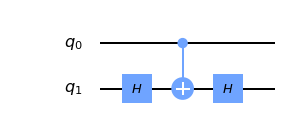

In [13]:
qc_cz = QuantumCircuit(2)
qc_cz.h(1)
qc_cz.cx(0,1)
qc_cz.h(1)
qc_cz.draw()

In [14]:
Z = np.array([1,0,0,-1]).reshape(2,2)
L6 = np.kron(G,np.eye(2**2))+np.kron(E,np.kron(np.eye(2),Z))
R6 = L6
U6 = L6@U5@R6
U6

array([[ 0.2706+0.j    , -0.6533+0.j    ,  0.    -0.6533j,  0.    -0.2706j,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [-0.6533+0.j    ,  0.2706+0.j    ,  0.    -0.2706j,  0.    -0.6533j,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    -0.6533j,  0.    -0.2706j,  0.2706+0.j    , -0.6533+0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    -0.2706j,  0.    -0.6533j, -0.6533+0.j    ,  0.2706+0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.2706+0.j    , -0.6533+0.j    ,  0.    -0.6533j,  0.    -0.2706j],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    , -0.6533+0.j    ,  0.2706+0.j    ,  0.    -0.2706j,  0.    -0.6533j],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    -0.6533j,  0.    -0.2706j,  0.2706+0.j    , -0.

Because it is no longer necessary to consider the third qubit, we remove it by defining $U_7 = A_5$.

In [15]:
U6 = U6[:4,:4]
U6

array([[ 0.2706+0.j    , -0.6533+0.j    ,  0.    -0.6533j,  0.    -0.2706j],
       [-0.6533+0.j    ,  0.2706+0.j    ,  0.    -0.2706j,  0.    -0.6533j],
       [ 0.    -0.6533j,  0.    -0.2706j,  0.2706+0.j    , -0.6533+0.j    ],
       [ 0.    -0.2706j,  0.    -0.6533j, -0.6533+0.j    ,  0.2706+0.j    ]])

We are again in the situation of the equation (5),
$$ U_6 = I\otimes A_6 + X\otimes B_6 = \begin{pmatrix} A_6 & B_6\\ B_6 & A_6 \end{pmatrix}.$$
We block diagonalize this operation with $L_7=R_7= H \otimes I = u3(\pi/2,0,\pi,1)$, obtaining
$$ U_7 = \begin{pmatrix} A_6+B_6 & 0 \\ 0 & A_6-B_6 \end{pmatrix}. $$

In [16]:
L7 = np.kron(H,np.eye(2))
R7 = L7
U7 = my_fun(L7@U6@R7)
U7

array([[ 0.2706-0.6533j, -0.6533-0.2706j,  0.    +0.j    ,  0.    +0.j    ],
       [-0.6533-0.2706j,  0.2706-0.6533j,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.2706+0.6533j, -0.6533+0.2706j],
       [ 0.    +0.j    ,  0.    +0.j    , -0.6533+0.2706j,  0.2706+0.6533j]])

Diagonalizing the first qubit with the operation $R_8=u3(\pi/2,-\pi/2,\pi/2,0)$, as well before

In [17]:
R8 = U7[:2,:2]
R8 = np.kron(np.eye(2), R8.conj().T/np.sqrt( (R8@R8.conj().T)[0,0] ) )
U8 = my_fun( U7@R8 ) 
U8

array([[ 1.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  1.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    , -0.7071-0.7071j],
       [ 0.    +0.j    ,  0.    +0.j    , -0.7071-0.7071j,  0.    +0.j    ]])

We only have to invert the last controlled operation to arrive to the identity matrix. 

In [18]:
Y = np.array([0,1,1,0]).reshape(2,2) 
R9 = np.kron(G,np.eye(2)) + np.kron(E,Y)
R10 = np.kron( np.array([1,0,0,np.exp(3j*np.pi/4)]).reshape(2,2)  , np.eye(2) ) 
U10 = my_fun(U8@R9@R10  ) 
U10 

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

Summarizing, we have found a set of operations that satisfy (1). Thereby, employing the equation (2), we can implement the transformation $U$. Finally, constructing the corresponding circuit,

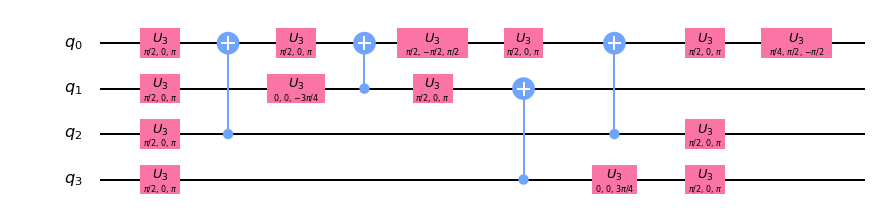

In [19]:
qc = QuantumCircuit(4)

qc.u3(np.pi/2,0,np.pi,3) #H

qc.u3(np.pi/2,0,np.pi,2) #H

qc.u3(np.pi/2,0,np.pi,0) #
qc.cx(2,0)               #CZ
qc.u3(np.pi/2,0,np.pi,0) #

qc.u3(np.pi/2,0,np.pi,1) #H

qc.u3(0,0,-3*np.pi/4,1) #R10
qc.cx(1,0) #CY

qc.u3(np.pi/2,-np.pi/2,np.pi/2,0) #R8

qc.u3(np.pi/2,0,np.pi,1) #H

qc.u3(np.pi/2,0,np.pi,0) #
qc.cx(2,0)               # CZ
qc.u3(np.pi/2,0,np.pi,0) #

qc.u3(np.pi/2,0,np.pi,2) #H

qc.u3(np.pi/4,np.pi/2,-np.pi/2,0) #R4

qc.cx(3,1)             # CX
qc.u3(0,0,3*np.pi/4,3) #

qc.u3(np.pi/2,0,np.pi,3) #H

qc.draw() 

Cheking the solution.

In [20]:
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.6465907683819627e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 54

Great! Your circuit meets all the constrains.
Your score is 54. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


The decomposition we found implements $ U $ with a very low error and a very good score of 54. Can we improve it? Of course! In first place, we can join two $u3$ gates as long as there is not a C-NOT between them.

In [21]:
get_angles_u3( u3_matrix([0,0,-3*np.pi/4])@u3_matrix([np.pi/2,0,np.pi]) )
get_angles_u3( u3_matrix([np.pi/2,0,np.pi])@u3_matrix([np.pi/2,-np.pi/2,np.pi/2]) )
get_angles_u3( u3_matrix([np.pi/4,np.pi/2,-np.pi/2])@u3_matrix([np.pi/2,0,np.pi]) )
get_angles_u3( u3_matrix([np.pi/2,0,np.pi])@u3_matrix([0,0,3*np.pi/4]) )

[0.5, 0.0, -0.2500000000000001, 0.0]

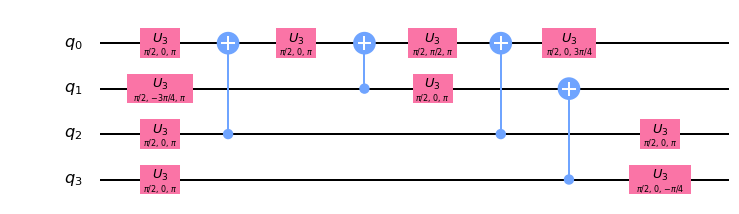

In [22]:
qc = QuantumCircuit(4)

qc.u3(np.pi/2,0,np.pi,3) 
qc.u3(np.pi/2,0,np.pi,2) 
qc.u3(np.pi/2,0,np.pi,0) 
qc.cx(2,0)               
qc.u3(np.pi/2,0,np.pi,0) 
qc.u3(np.pi/2,-3*np.pi/4,np.pi,1) 
qc.cx(1,0) 
qc.u3(np.pi/2,np.pi/2,np.pi,0) 
qc.u3(np.pi/2,0,np.pi,1) 
qc.cx(2,0)               
qc.u3(np.pi/2,0,3*np.pi/4,0)
qc.u3(np.pi/2,0,np.pi,2) 
qc.cx(3,1)             #
qc.u3(np.pi/2,0,-np.pi/4,3) 
qc.draw() 

In [23]:
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.6370979769189543e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 50

Great! Your circuit meets all the constrains.
Your score is 50. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!


We improve the cost from 54 to 50 without loss of precision! Now, we can reduce more the circuit using the following identity to exchange control and target of a C-NOT:

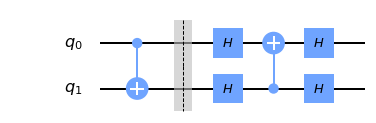

In [24]:
#The best property of the world 
qc_prop = QuantumCircuit(2)
qc_prop.cx(0,1)
qc_prop.barrier()
qc_prop.h([0,1])
qc_prop.cx(1,0)
qc_prop.h([0,1])
qc_prop.draw()

In [25]:
my_fun(execute(qc_prop, unitary_simulator).result().get_unitary())

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

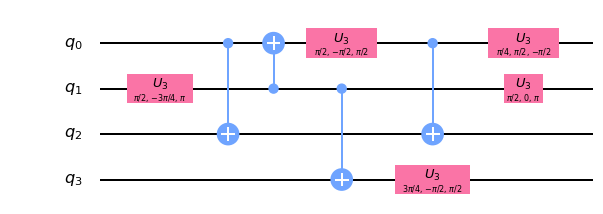

In [26]:
qc = QuantumCircuit(4)

qc.u3(np.pi/2,-3*np.pi/4,np.pi,1) 
qc.cx(0,2)  
qc.cx(1,0) 
qc.u3(np.pi/2,-np.pi/2,np.pi/2,0) 
qc.cx(0,2)         
qc.u3(np.pi/4,np.pi/2,-np.pi/2,0) 
qc.cx(1,3)      
qc.u3(np.pi/2,0,np.pi,1) 
qc.u3(3*np.pi/4,-np.pi/2,np.pi/2,3) 

qc.draw() 

Making a final check, we obtain a cost of 45! That is, an implementation of $U$ with only $4$ C-NOTs and $5$ $u3$ gates.

In [27]:
check_circuit(qc)

Circuit stats:
||U-V||_2 = 1.5226109532611476e-15
(U is the reference unitary, V is yours, and the global phase has been removed from both of them).
Cost is 45

Great! Your circuit meets all the constrains.
Your score is 45. The lower, the better!
Feel free to submit your answer and remember you can re-submit a new circuit at any time!
